In [1]:
from PandasToolsFunction import *
from DataPreprocessingTools import *
import pandas as pd
from tqdm import tqdm
import json

# Formatting data

In [3]:
def covid_remover(data: pd.DataFrame):
    
    covid_removed_data = data.copy()

    covid_time = make_date_filter(covid_removed_data, start_date='2020-02-01', end_date='2021-11-01')
    covid_removed_data = covid_removed_data[~covid_time]
    return covid_removed_data

In [16]:
# Formatting train_data

# Charger les données d'entraînement
trainf_data = pd.read_csv('train_f_x.csv')
y_train_data = pd.read_csv('y_train_sncf.csv')

train_data = trainf_data
train_data['y'] = y_train_data['y']
train_data['date'] = pd.to_datetime(train_data['date'])

existing_column_index = train_data.columns.get_loc('date')
# Use the insert method to add the new column after the existing column
train_data.insert(existing_column_index + 1, 'day_name', train_data['date'].dt.day_name())

"""train_data.to_csv('train_data_with_day_of_week.csv')
train_data = covid_remover(train_data)
train_data.to_csv('train_data_woCov_with_day_of_week.csv')"""

after_covid_filter = make_date_filter(train_data, start_date='2021-11-01')
train_data_after_covid = train_data[after_covid_filter]
train_data_after_covid.to_csv('train_data_afterCov_with_day_of_week.csv')

In [ ]:
# Formatting test_data



In [ ]:
def train_data_formatting(data: pd.DataFrame) -> pd.DataFrame :
    """
    accolate
    """
    pass


In [2]:
test_data = pd.read_csv('test_f_x_THurtzP.csv')
test_data.head()

,index,date,station,job,ferie,vacances
0,2023-01-01_1J7,2023-01-01,1J7,0,1,1
1,2023-01-01_O2O,2023-01-01,O2O,0,1,1
2,2023-01-01_8QR,2023-01-01,8QR,0,1,1
3,2023-01-01_L58,2023-01-01,L58,0,1,1
4,2023-01-01_UMC,2023-01-01,UMC,0,1,1


In [10]:
train_data = pd.read_csv('train_f_x.csv')
covid_proof_train_data = covid_remover(train_data)

In [11]:
display_by_station(covid_proof_train_data, stations=1, display_mode='dates')

ValueError: Could not interpret value `y` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [27]:
def data_day_typer(data_init: pd.DataFrame):

    data = data_init.copy()
    
    for index, row in data.iterrows():
        if row['ferie'] == 1:
            data.at[index, 'day_type'] = 'ferie'
        elif row['vacances'] == 1: 
            data.at[index, 'day_type'] = 'vacances'
        elif row['job'] == 1:
            data.at[index, 'day_type'] = 'job'
        else:
            data.at[index, 'day_type'] = 'job'

    for day_type_col in ['job', 'ferie', 'vacances']:
        data.pop(day_type_col)

    return data

In [28]:
test_data1= data_day_typer(test_data)
test_data1

,index,date,station,day_type
0,2023-01-01_1J7,2023-01-01,1J7,ferie
1,2023-01-01_O2O,2023-01-01,O2O,ferie
2,2023-01-01_8QR,2023-01-01,8QR,ferie
3,2023-01-01_L58,2023-01-01,L58,ferie
4,2023-01-01_UMC,2023-01-01,UMC,ferie
...,...,...,...,...
78647,2023-05-31_N9K,2023-05-31,N9K,job
78648,2023-05-31_P6E,2023-05-31,P6E,job
78649,2023-05-31_BDC,2023-05-31,BDC,job
78650,2023-05-31_QD6,2023-05-31,QD6,job


In [7]:
test_data

,index,date,station,job,ferie,vacances,day_type
0,2023-01-01_1J7,2023-01-01,1J7,0,1,1,ferie
1,2023-01-01_O2O,2023-01-01,O2O,0,1,1,ferie
2,2023-01-01_8QR,2023-01-01,8QR,0,1,1,ferie
3,2023-01-01_L58,2023-01-01,L58,0,1,1,ferie
4,2023-01-01_UMC,2023-01-01,UMC,0,1,1,ferie
...,...,...,...,...,...,...,...
78647,2023-05-31_N9K,2023-05-31,N9K,1,0,0,job
78648,2023-05-31_P6E,2023-05-31,P6E,1,0,0,job
78649,2023-05-31_BDC,2023-05-31,BDC,1,0,0,job
78650,2023-05-31_QD6,2023-05-31,QD6,1,0,0,job


# Data Anomaly elimination

In [2]:
def data_anomaly_elimination(data_init: pd.DataFrame, alpha=1e-4):
    data = data_init.copy()

    elimination_counts = {}
    elimination_percentages = {}
    for station in tqdm(data['station'].unique()):
        station_count = 0

        for day_type in ['job', 'ferie', 'vacances']: # Our day types will form a partition.
            mask = (data['station'] == station) & (data[day_type] == 1)
            station_day_type_data = data[mask]

            lower_bound, upper_bound = IC(station_day_type_data['y'], alpha)

            # Keep only the data points within the confidence interval
            previous_size = len(data)
            data = data[~((mask) & ((data['y'] < lower_bound) | (data['y'] > upper_bound)))]
            
            station_count += previous_size - len(data)
        elimination_counts[station] = station_count
        elimination_percentages[station] = station_count/sum(data_init['station'] == station)

    return data, elimination_counts, elimination_percentages

In [4]:
# Charger les données d'entraînement
trainf_data = pd.read_csv('train_f_x.csv')
y_train_data = pd.read_csv('y_train_sncf.csv')

train_data = trainf_data
train_data['y'] = y_train_data['y']

In [70]:
anomaly_eliminated_data, elimination_counts, elimination_percentages = data_anomaly_elimination(train_data)

100%|██████████| 439/439 [01:55<00:00,  3.80it/s]


In [72]:

anomaly_eliminated_data.to_csv("anomaly_eliminated_train_alpha1e-4", index=False)

with open("anomaly_elimination_count_alpha1e-4", 'w') as json_file:
    json.dump(elimination_counts, json_file)

In [9]:
anomaly_eliminated_data = pd.read_csv("anomaly_eliminated_train_alpha1e-4")

# Load the dictionary from the JSON file
with open("anomaly_elimination_count_alpha1e-4", 'r') as json_file:
    elimination_counts = json.load(json_file)

In [12]:
"""max_anormal_station_idx = np.argmax(np.array(list(elimination_counts.values())))
max_anormal_station = list(elimination_counts.keys())[max_anormal_station_idx]
print(max_anormal_station)"""

max_anormal_station = max(elimination_counts, key=elimination_counts.get)

print(max_anormal_station)


B9M


Regarder les gares qui ont des grosses anomalies (en intensité et non en fréquence comme fait ci-dessus)

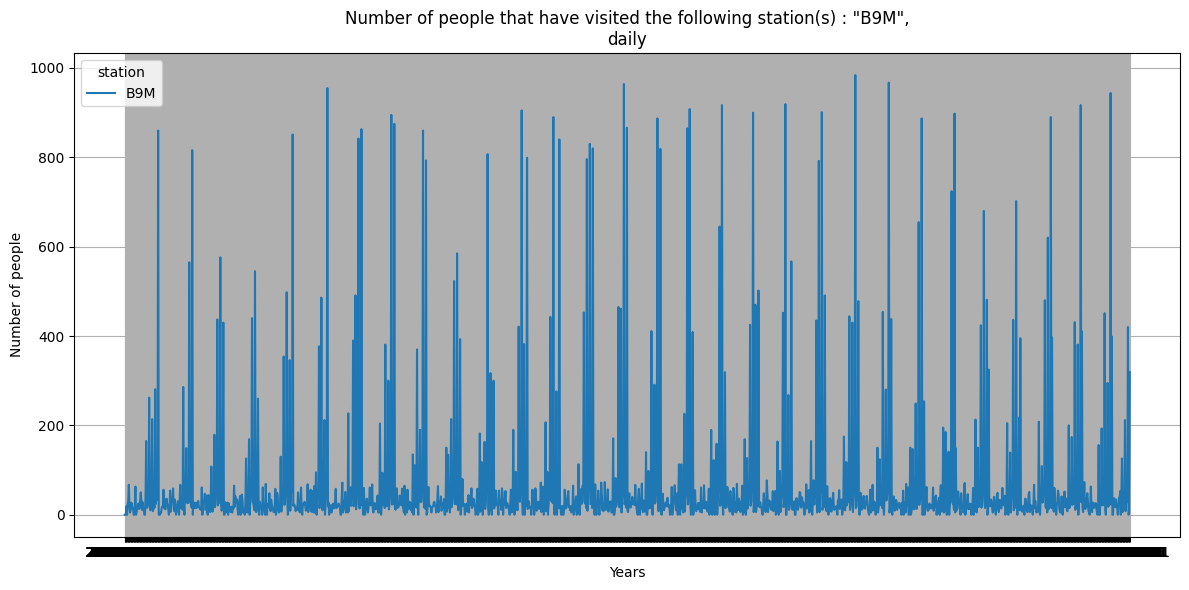

,date,station,job,ferie,vacances,y
140,2015-01-01,B9M,1,1,1,0
565,2016-01-01,B9M,1,1,1,0
990,2017-01-01,B9M,0,1,1,0
1837,2019-01-01,B9M,1,1,1,19
3453,2015-02-01,B9M,0,0,0,0
...,...,...,...,...,...,...
1224551,2018-10-31,B9M,1,0,1,29
1226226,2022-10-31,B9M,1,0,1,420
1227087,2016-12-31,B9M,0,0,1,0
1227938,2018-12-31,B9M,1,0,1,5


In [13]:
display_by_station(train_data, stations=[max_anormal_station])

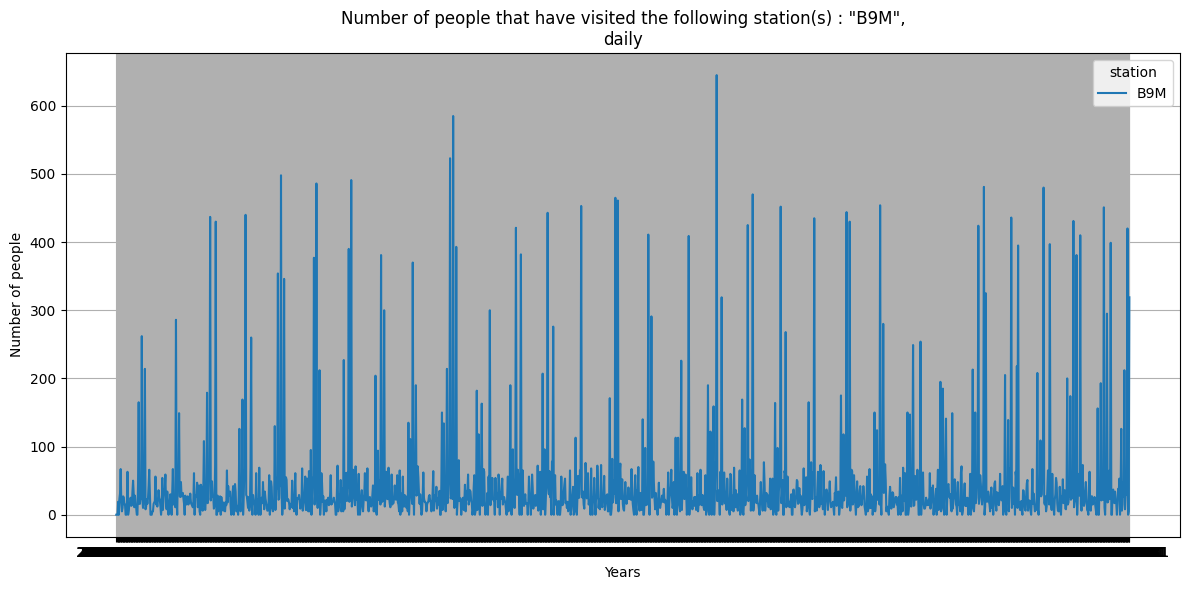

,date,station,job,ferie,vacances,y
140,2015-01-01,B9M,1,1,1,0
565,2016-01-01,B9M,1,1,1,0
990,2017-01-01,B9M,0,1,1,0
1837,2019-01-01,B9M,1,1,1,19
3453,2015-02-01,B9M,0,0,0,0
...,...,...,...,...,...,...
1224006,2018-10-31,B9M,1,0,1,29
1225681,2022-10-31,B9M,1,0,1,420
1226542,2016-12-31,B9M,0,0,1,0
1227393,2018-12-31,B9M,1,0,1,5


In [14]:
display_by_station(anomaly_eliminated_data, stations=[max_anormal_station])

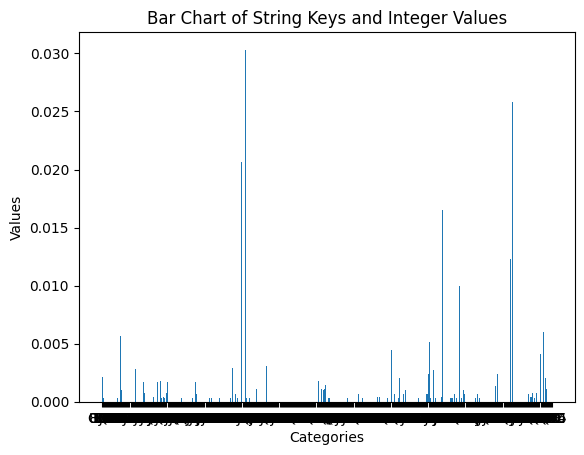

In [73]:
import matplotlib.pyplot as plt


keys = list(elimination_percentages.keys())
values = list(elimination_percentages.values())

plt.bar(keys, values)
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar Chart of String Keys and Integer Values')
plt.show()
